<a href="https://colab.research.google.com/github/aadityadamle/News_Aggregator/blob/master/NER.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [36]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import LSTM, Embedding, Dense
from tensorflow.keras.layers import TimeDistributed, SpatialDropout1D, Bidirectional
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [3]:
data=pd.read_csv('https://raw.githubusercontent.com/abcom-mltutorials/emotition-detector/master/ner_dataset.csv',encoding='latin1')
data=data.fillna(method="ffill")

HTTPError: ignored

In [6]:
data = pd.read_csv("https://raw.githubusercontent.com/abcom-mltutorials/NEWSAggregator/77cab1631b3bddd1c3ae91940c6de2d48891a5f1/ner_dataset.csv", encoding="latin1")
data = data.fillna(method = "ffill")

In [7]:
data.head()

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,Sentence: 1,of,IN,O
2,Sentence: 1,demonstrators,NNS,O
3,Sentence: 1,have,VBP,O
4,Sentence: 1,marched,VBN,O


In [8]:
data.Tag.unique()

array(['O', 'B-geo', 'B-gpe', 'B-per', 'I-geo', 'B-org', 'I-org', 'B-tim',
       'B-art', 'I-art', 'I-per', 'I-gpe', 'I-tim', 'B-nat', 'B-eve',
       'I-eve', 'I-nat'], dtype=object)

In [10]:
data.columns = ["sentence", "Word", "POS", "Tag"]

In [12]:
print("Sentence #2:"," ".join(data[data.sentence == "Sentence: 2"].Word.tolist()))

Sentence #2: Families of soldiers killed in the conflict joined the protesters who carried banners with such slogans as " Bush Number One Terrorist " and " Stop the Bombings . "


In [14]:
print("Sentece #5"," ".join(data[data.sentence == "Sentence: 5"].Word.tolist()))

Sentece #5 The protest comes on the eve of the annual conference of Britain 's ruling Labor Party in the southern English seaside resort of Brighton .


In [23]:
print("Sentence #4000"," ".join(data[data.sentence == "Sentence: 4000"].Word.tolist()))

Sentence #4000 The march was the first of three large demonstrations planned for the summit .


In [15]:
words=list(set(data["Word"].values))
words.append("ENDPAD")
num_words=len(words)
tags=list(set(data["Tag"].values))
num_tags=len(tags)
print ("Number of unique words: ", num_words)
print ("Number of unique tags: ", num_tags)

Number of unique words:  35179
Number of unique tags:  17


In [18]:
def sentencegetter(data):
  agg_func = lambda s:[(w,p,t) for w,p,t in zip(s["Word"].values.tolist(),s["POS"].values.tolist(),s['Tag'].values.tolist())]
  grouped=data.groupby("sentence").apply(agg_func)
  sentences=[s for s in grouped]
  return sentences


In [19]:
sentences = sentencegetter(data)

In [20]:
sentences[0]


[('Thousands', 'NNS', 'O'),
 ('of', 'IN', 'O'),
 ('demonstrators', 'NNS', 'O'),
 ('have', 'VBP', 'O'),
 ('marched', 'VBN', 'O'),
 ('through', 'IN', 'O'),
 ('London', 'NNP', 'B-geo'),
 ('to', 'TO', 'O'),
 ('protest', 'VB', 'O'),
 ('the', 'DT', 'O'),
 ('war', 'NN', 'O'),
 ('in', 'IN', 'O'),
 ('Iraq', 'NNP', 'B-geo'),
 ('and', 'CC', 'O'),
 ('demand', 'VB', 'O'),
 ('the', 'DT', 'O'),
 ('withdrawal', 'NN', 'O'),
 ('of', 'IN', 'O'),
 ('British', 'JJ', 'B-gpe'),
 ('troops', 'NNS', 'O'),
 ('from', 'IN', 'O'),
 ('that', 'DT', 'O'),
 ('country', 'NN', 'O'),
 ('.', '.', 'O')]

In [21]:
word2idx={w:i+1 for i , w in enumerate(words)} #i+1 because we created endpad so we have to add 1 to index endpad
tag2idx={t:i for i,t in enumerate(tags)}
tag2idx

{'B-art': 16,
 'B-eve': 9,
 'B-geo': 12,
 'B-gpe': 8,
 'B-nat': 3,
 'B-org': 13,
 'B-per': 4,
 'B-tim': 14,
 'I-art': 15,
 'I-eve': 1,
 'I-geo': 0,
 'I-gpe': 6,
 'I-nat': 10,
 'I-org': 5,
 'I-per': 2,
 'I-tim': 7,
 'O': 11}

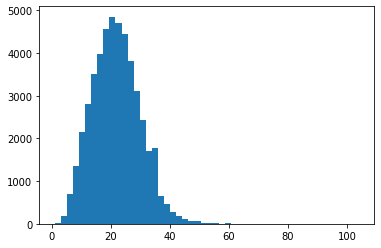

In [22]:
plt.hist([len(s) for s in sentences],bins=50)
plt.show() # In the following graph horizontal axis represents length and verical axis represents sentence no. 

In [24]:
# its clear from the graph that max. length is 50 
max_len= 50
X= [[word2idx[w[0]] for w in s ] for s in sentences]
X=pad_sequences(maxlen=max_len,sequences=X,padding="post", value=num_words-1)

In [25]:
X[1]

array([10032, 11896, 33747, 20278, 34059, 22598, 19310, 34995, 22598,
       12751, 13031, 28036, 24808, 21297, 11475, 28007,  7907, 22857,
       33192,  5780, 18807,  7510, 25587, 10974, 16827, 35178, 35178,
       35178, 35178, 35178, 35178, 35178, 35178, 35178, 35178, 35178,
       35178, 35178, 35178, 35178, 35178, 35178, 35178, 35178, 35178,
       35178, 35178, 35178, 35178, 35178], dtype=int32)

In [26]:
#target vector
y=[[tag2idx[w[2]] for w in s ] for s in sentences]
y=pad_sequences(maxlen=max_len,sequences=y,padding="post",value=tag2idx["O"]) #doubts 
y=[to_categorical(i,num_classes=num_tags) for i in y] 
#one hot encoding the target tag

In [27]:
# dataset split 0.9:0.1 
xtrain,xtest,ytrain,ytest=train_test_split(X,y,test_size=0.1,random_state=1)

In [29]:
#model
input_word=Input(shape=(max_len,)) #input layer
model=Embedding(input_dim=num_words,output_dim=max_len,input_length=max_len)(input_word)
model= SpatialDropout1D(0.1)(model) #regularization
# bidirectional for learning across the entire sequence
model=Bidirectional(LSTM(units=100,return_sequences=True,recurrent_dropout=0.1))(model)
out=TimeDistributed(Dense(num_tags,activation="softmax"))(model) # Is this step similar to normalization
model=Model(input_word,out)

In [30]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 50)]              0         
_________________________________________________________________
embedding (Embedding)        (None, 50, 50)            1758950   
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 50, 50)            0         
_________________________________________________________________
bidirectional (Bidirectional (None, 50, 200)           120800    
_________________________________________________________________
time_distributed (TimeDistri (None, 50, 17)            3417      
Total params: 1,883,167
Trainable params: 1,883,167
Non-trainable params: 0
_________________________________________________________________


In [31]:
model.compile(optimizer="adam",loss="categorical_crossentropy",metrics=['accuracy'])

In [38]:

history=model.fit(xtrain,np.array(ytrain),validation_split=0.2,batch_size=32,epochs=5,verbose=1)

Epoch 1/5
1080/1080 [==============================] - 209s 193ms/step - loss: 0.1884 - accuracy: 0.9559 - val_loss: 0.0713 - val_accuracy: 0.9792
Epoch 2/5
1080/1080 [==============================] - 209s 194ms/step - loss: 0.0535 - accuracy: 0.9842 - val_loss: 0.0504 - val_accuracy: 0.9845
Epoch 3/5
1080/1080 [==============================] - 210s 194ms/step - loss: 0.0383 - accuracy: 0.9883 - val_loss: 0.0480 - val_accuracy: 0.9855
Epoch 4/5
1080/1080 [==============================] - 210s 195ms/step - loss: 0.0315 - accuracy: 0.9901 - val_loss: 0.0475 - val_accuracy: 0.9857
Epoch 5/5
1080/1080 [==============================] - 210s 195ms/step - loss: 0.0275 - accuracy: 0.9912 - val_loss: 0.0483 - val_accuracy: 0.9858


In [39]:
model.evaluate(xtest,np.array(ytest))

150/150 [==============================] - 4s 26ms/step - loss: 0.0499 - accuracy: 0.9856


[0.04986099526286125, 0.9856338500976562]

In [40]:
i = np.random.randint(0,xtest.shape[0])

In [41]:
p=model.predict(np.array([xtest[i]]))


In [42]:
p=np.argmax(p,axis=-1)

In [45]:
y_true=np.argmax(np.array(ytest),axis=-1)[i]
#Print the prediction results and compare with true values.
print("{:15}{:5}\t {}\n".format("word","True","pred"))
print("-"*30)
for w,true,pred in zip(xtest[i],y_true,p[0]):
    print("{:15}{}\t{}".format(words[w-1],tags[true],tags[pred]))

word           True 	 pred

------------------------------
National       O	O
elections      O	O
in             O	O
July           B-tim	B-tim
2008           I-tim	I-tim
were           O	O
relatively     O	O
peaceful       O	O
.              O	O
Huaren         O	O
Huaren         O	O
Huaren         O	O
Huaren         O	O
Huaren         O	O
Huaren         O	O
Huaren         O	O
Huaren         O	O
Huaren         O	O
Huaren         O	O
Huaren         O	O
Huaren         O	O
Huaren         O	O
Huaren         O	O
Huaren         O	O
Huaren         O	O
Huaren         O	O
Huaren         O	O
Huaren         O	O
Huaren         O	O
Huaren         O	O
Huaren         O	O
Huaren         O	O
Huaren         O	O
Huaren         O	O
Huaren         O	O
Huaren         O	O
Huaren         O	O
Huaren         O	O
Huaren         O	O
Huaren         O	O
Huaren         O	O
Huaren         O	O
Huaren         O	O
Huaren         O	O
Huaren         O	O
Huaren         O	O
Huaren         O	O
Huaren         O	O
Huaren       

In [46]:
# testing with an unseen sentence:
sentence="About 1,500 doctors , scientists and health workers are expected to attend the week-long Pan-Africa malaria conference in Cameroon 's capital , Yaounde "
seq=[]
for word in sentence.split():
  if word in list(word2idx.keys()):
    idx=word2idx[word]
    seq.append(idx)

In [47]:
pad_seq=pad_sequences([seq],padding='post',maxlen=50)

In [48]:
p=model.predict(pad_seq)
p=np.argmax(p,axis=-1)

In [49]:
print("{:10}\t {}\n".format("word","pred"))
print("-"*30)
for w,pred in zip(pad_seq.tolist()[0],p[0]):
 print("{:10}\t{}".format(words[w-1],tags[pred]))

word      	 pred

------------------------------
About     	O
1,500     	O
doctors   	O
,         	O
scientists	O
and       	O
health    	O
workers   	O
are       	O
expected  	O
to        	O
attend    	O
the       	O
week-long 	B-tim
Pan-Africa	O
malaria   	O
conference	O
in        	O
Cameroon  	B-geo
's        	O
capital   	O
,         	O
Yaounde   	O
ENDPAD    	I-per
ENDPAD    	I-per
ENDPAD    	I-org
ENDPAD    	I-org
ENDPAD    	I-org
ENDPAD    	I-org
ENDPAD    	O
ENDPAD    	O
ENDPAD    	O
ENDPAD    	O
ENDPAD    	O
ENDPAD    	O
ENDPAD    	O
ENDPAD    	O
ENDPAD    	O
ENDPAD    	O
ENDPAD    	I-per
ENDPAD    	I-per
ENDPAD    	I-per
ENDPAD    	I-geo
ENDPAD    	I-geo
ENDPAD    	I-geo
ENDPAD    	I-geo
ENDPAD    	I-geo
ENDPAD    	I-geo
ENDPAD    	I-geo
ENDPAD    	I-geo
